In [1]:
import torch
import torch.nn as nn
import numpy as np
from GPT2 import GPT2Model, GPT2Tokenizer

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = 'cuda' #'cuda'

tokenizer = GPT2Tokenizer(
    'GPT2/bpe/vocab.json',
    'GPT2/bpe/chinese_vocab.model',
    max_len=512)

class GPT2classification(nn.Module):
    def __init__(self):
        super(GPT2classification, self).__init__()
        
        self.GPT2model = GPT2Model(
                            vocab_size=30000,
                            layer_size=12,
                            block_size=1024,
                            embedding_dropout=0.0,
                            embedding_size=768,
                            num_attention_heads=12,
                            attention_dropout=0.0,
                            residual_dropout=0.0)

        self.mlp =  nn.Sequential(
                nn.Linear(30000, 512),
                nn.ReLU(),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Linear(256, 2),
            )

    def forward(self, x, length):
        x = self.GPT2model(x)
        classify = []
        for i in range(len(length)):
            classify.append(x[i, length[i]].view(-1))
        classify = torch.stack(classify)
        x = self.mlp(classify)
        return x

In [2]:
import json
from GPT2.samplers import RandomSampler
from torch.utils.data import TensorDataset
from tqdm import tqdm

def load_tnews_data(data_path, data_type, tokenizer, few_shot=False, seq_length=1024):

    filename = os.path.join(data_path, data_type+'.json')
    objs = []
    with open(filename) as fin:
        for line in fin:
            objs.append(json.loads(line.strip()))

    objs = objs[:len(objs)//10]

    pad_id = tokenizer.encoder['<pad>']

    all_tokens = []
    all_last_idx = []
    all_labels = []
    
    for _, obj in enumerate(tqdm(objs)):
        sentence = obj['sentence']
        tokenized_sentence = tokenizer.encode(sentence)[:seq_length-20]
        if obj['label_desc'] == 'news_finance':
            label = 1
        else:
            label = 0

        all_labels.append(label)

        tokens = tokenized_sentence
        token_length = len(tokens)
        tokens.extend([pad_id] * (seq_length - token_length))

        all_last_idx.append(token_length)
        all_tokens.append(tokens)
    
    all_tokens = torch.tensor(all_tokens, dtype=torch.long)
    all_last_idx = torch.tensor(all_last_idx, dtype=torch.long)
    all_labels = torch.tensor(all_labels, dtype=torch.long)
    
    dataset = TensorDataset(all_tokens, all_last_idx, all_labels)

    return dataset
  
def collect_fcn(batch):
    bs = len(batch)
    batch_tokens = []
    batch_idx = []
    batch_labels = []
    for i in range(bs):
        batch_tokens.append(batch[i][0])
        batch_idx.append(batch[i][1])
        batch_labels.append(batch[i][2])
    batch_tokens = torch.stack(batch_tokens)
    batch_idx = torch.stack(batch_idx)
    batch_labels = torch.stack(batch_labels)

    return batch_tokens, batch_idx, batch_labels

In [3]:
model = torch.load("../models/financial_finetune_eng_5.pth", map_location='cpu')
model.eval()
model.to(device)

GPT2classification(
  (GPT2model): GPT2Model(
    (word_embeddings): Embedding(30000, 768)
    (position_embeddings): Embedding(1024, 768)
    (emb_drop): Dropout(p=0.0, inplace=False)
    (transformer): Transformer(
      (layers): ModuleList(
        (0): Block(
          (input_layernorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attention): Attention(
            (query_key_value): Linear(in_features=768, out_features=2304, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (resid_drop): Dropout(p=0.0, inplace=False)
            (dense): Linear(in_features=768, out_features=768, bias=True)
          )
          (post_attention_layernorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): MLP(
            (dense_h_to_4h): Linear(in_features=768, out_features=3072, bias=True)
            (dense_4h_to_h): Linear(in_features=3072, out_features=768, bias=True)
          )
        )
        (1): Block(
          (inp

In [4]:
test_set = load_tnews_data('../dataset/THUCNews_processed', 'test_financial_ag', tokenizer)
sampler = RandomSampler(test_set)
test_dataloader = torch.utils.data.DataLoader(test_set,
                                                batch_size = 1,
                                                sampler=sampler,
                                                num_workers=0,
                                                collate_fn = collect_fcn,
                                                pin_memory=True)

  0%|          | 0/600 [00:00<?, ?it/s]Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.721 seconds.
Prefix dict has been built successfully.
100%|██████████| 600/600 [00:01<00:00, 463.50it/s]


In [5]:
num_financial = 0
num_others = 0
num_financial_true = 0
num_others_true = 0
financial_list = []
others_list = []

for i, batch in enumerate(tqdm(test_dataloader)):
    token, last_idx, label = (x.to(device) for x in batch)
    output = model(token, last_idx)
    if label[0] == 1:
        if output[0, 0] < output[0, 1]:
            num_financial_true = num_financial_true + 1
        num_financial = num_financial + 1
        financial_list.append(output.detach().cpu().numpy())
    else:
        if output[0, 0] > output[0, 1]:
            num_others_true = num_others_true + 1
        num_others = num_others + 1
        others_list.append(output.detach().cpu().numpy())

financial_list = np.array(financial_list).reshape(-1,2)
others_list = np.array(others_list).reshape(-1,2)

100%|██████████| 600/600 [00:32<00:00, 18.19it/s]


In [6]:
print(num_financial_true)
print(num_financial)
print(num_others_true)
print(num_others)

print(num_financial_true/num_financial)
print(num_others_true/num_others)

243
294
266
306
0.826530612244898
0.869281045751634


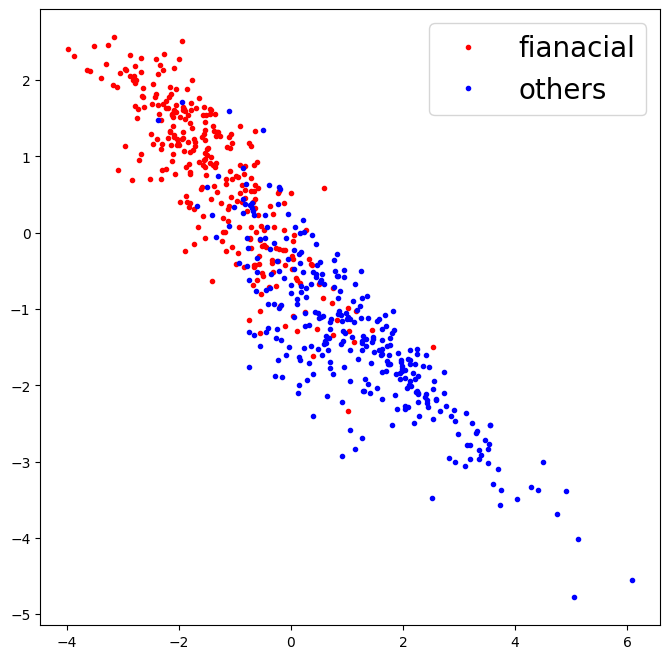

In [7]:
import matplotlib.pyplot as plt
# %matplotlib inline
plt.style.use('default')
plt.figure(figsize=(8,8))
plt.plot(financial_list[:1000, 0], financial_list[:1000, 1], '.', c='r', label='fianacial')
plt.plot(others_list[:1000, 0], others_list[:1000, 1], '.', c='b', label='others')
plt.legend(prop={'size': 20})
plt.show()